In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')
import math
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils.multiclass import unique_labels

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
data = pd.read_csv('telco_churn.csv')

In [5]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(data[data.columns[:-1]], data[['Churn']])
filt_data = np.append(x_res, y_res, axis=1)
filt_data = pd.DataFrame(filt_data, columns = data.columns)

In [7]:
filt_data.loc[filt_data['TotalCharges'] == ' ', 'TotalCharges'] = 0
filt_data.TotalCharges = filt_data.TotalCharges.astype(float)
filt_data.MonthlyCharges = filt_data.MonthlyCharges.astype(float)
filt_data.SeniorCitizen = filt_data.SeniorCitizen.astype(str)
filt_data.tenure = filt_data.tenure.astype(str)

# SVM with Kernel function

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

columns_to_encode = filt_data.columns[1:-3]
columns_to_scale = filt_data.columns[-3:-1]
numeric_columns = filt_data[filt_data.columns[-3:-1]]

scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

encoded_columns =  ohe.fit_transform(filt_data[columns_to_encode])
scaled_columns  = scaler.fit_transform(filt_data[columns_to_scale]) 
labels = np.array([1 if x == 'Yes' else 0 for x in filt_data['Churn'].values])

# Concatenate (Column-Bind) Processed Columns Back Together
processed_data = np.concatenate([scaled_columns, encoded_columns], axis=1)
processed_data = np.concatenate([processed_data, labels.reshape([len(labels), 1])], axis=1)

In [9]:
svm_train, svm_test = train_test_split(processed_data, test_size=0.2)

In [10]:
y_train2 = svm_train[:,-1]
x_train2 = svm_train[:,0:-1]
y_test2 = svm_test[:,-1]
x_test2 = svm_test[:,0:-1]

In [11]:
from sklearn.svm import SVC

clf = SVC()
clf.set_params(kernel='rbf', gamma='scale', probability=True).fit(x_train2, y_train2)
y_pred2 = clf.predict(x_test2)
acc2 = sum(y_pred2 == y_test2) / len(y_test2)
pred_probs = clf.predict_proba(x_test2)
print(acc2)

0.7901069518716578


In [12]:
clf.set_params(kernel='poly', gamma='scale').fit(x_train2, y_train2)
y_pred3 = clf.predict(x_test2)
acc3 = sum(y_pred3 == y_test2) / len(y_test2)
print(acc3)

0.7834224598930482


In [13]:
clf.set_params(kernel='sigmoid', gamma='scale').fit(x_train2, y_train2)
y_pred4 = clf.predict(x_test2)
acc4 = sum(y_pred4 == y_test2) / len(y_test2)
print(acc4)

0.6911764705882353


Confusion matrix, without normalization


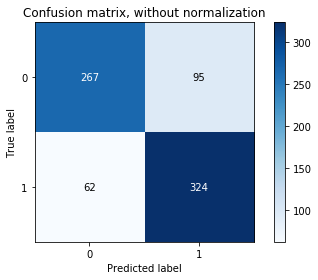

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test2, y_pred2, classes=["No","Yes"],
                      title='Confusion matrix, without normalization')

plt.show()

In [15]:
fpr2, tpr2, thresholds2 = roc_curve(y_test2, pred_probs[:,1], pos_label=1)
roc_auc = auc(fpr2, tpr2)

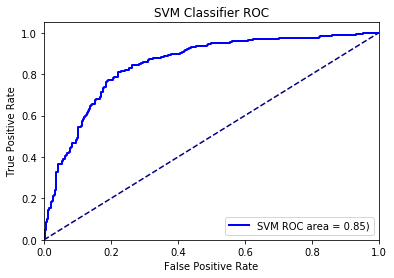

In [16]:
#GRAPH DATA
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('SVM Classifier ROC')
plt.plot(fpr2, tpr2, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

# Boosting Tree Classifier

In [17]:
train, test = train_test_split(filt_data, test_size=0.2)

In [18]:
y_train = train[['Churn']]
x_train = train[train.columns[1:-1]]
y_test = test[['Churn']]
x_test = test[test.columns[1:-1]]

In [19]:
x_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3598,Male,0,Yes,No,70,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),115.65,7968.85
187,Female,0,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,No,Electronic check,109.30,7337.55
1528,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,39.25
429,Female,0,No,No,20,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,406.95
1596,Female,0,Yes,No,60,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),60.80,3603.45


In [20]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = x_train.columns[:-2]
NUMERIC_COLUMNS = x_train.columns[-2:]

print(CATEGORICAL_COLUMNS)
print(NUMERIC_COLUMNS)
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(fc.categorical_column_with_vocabulary_list(feature_name,vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = x_train[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
Index(['MonthlyCharges', 'TotalCharges'], dtype='object')


In [21]:
y_train_encoded = [1 if x == 'Yes' else 0 for x in y_train['Churn'].values]
y_test_encoded = [1 if x == 'Yes' else 0 for x in y_test['Churn'].values]

In [22]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)  
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(x_train, y_train_encoded)
test_input_fn = make_input_fn(x_test, y_test_encoded, shuffle=False, n_epochs=1)

In [23]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches, center_bias=True)
est.train(train_input_fn, max_steps=100)
results = est.evaluate(test_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/7w/hckjt_kn7f51_846s0zkt9m40000gn/T/tmpyruu27vx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10401aa58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new Feat

In [24]:
pred_dicts = list(est.experimental_predict_with_explanations(test_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/7w/hckjt_kn7f51_846s0zkt9m40000gn/T/tmpyruu27vx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x121b2a780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring pa

In [25]:
y_pred = []
y_score = []
for idx,entry in enumerate(pred_dicts):
    y_pred.append(pred_dicts[idx]['class_ids'][0])
    y_score.append(pred_dicts[idx]['probabilities'][1])

Confusion matrix, without normalization


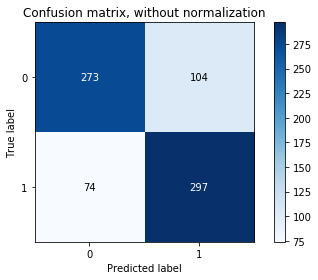

In [26]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, classes=["No","Yes"],
                      title='Confusion matrix, without normalization')

plt.show()

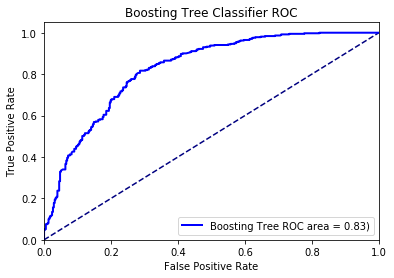

In [27]:
fpr, tpr, thresholds = roc_curve(np.array(y_test_encoded), np.array(y_score),pos_label=1)
roc_auc2 = auc(fpr, tpr)

#GRAPH DATA
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Boosting Tree Classifier ROC')
plt.plot(fpr, tpr, color='blue', lw=2, label='Boosting Tree ROC area = %0.2f)' % roc_auc2)
plt.legend(loc="lower right")
plt.show()

In [28]:
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
encoded_elems = []
for name in CATEGORICAL_COLUMNS:
    encoded_elems.append(len(filt_data[name].unique()))
print(encoded_elems)

[2, 2, 2, 2, 73, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4]


In [55]:
row = df_dfc.iloc[[4]]
#747

idx = 0
dfcs = []
for elem in encoded_elems:
    dfcs.append(sum(row.values[0][idx:idx+elem]))
    idx += elem
print(dfcs)
len(dfcs)

[0.0012301841104823685, 0.0331004907969491, 0.0, 0.0005851453494986059, 0.30332423771948935, -5.019558279029113e-07, -0.0011301702551825832, 0.012015706750093669, 0.001239558297566834, -0.0015909655179093818, -9.750607472780448e-05, 0.0, 0.011018980767339315, 0.0, -0.0024081001442146643, 0.0, 0.0]


17

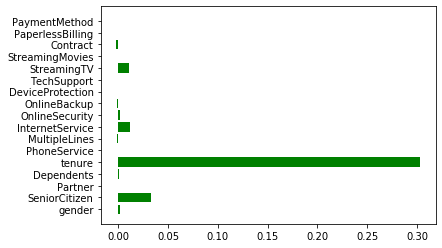

In [56]:
marks=[dfcs[0],dfcs[1],dfcs[2],dfcs[3],dfcs[4],dfcs[5],dfcs[6],dfcs[7],dfcs[8],dfcs[9],dfcs[10],dfcs[11],dfcs[12],dfcs[13],dfcs[14],dfcs[15],dfcs[16]]
bars=('gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod')         
y=np.arange(len(bars))
plt.barh(y,marks,color='g')
plt.yticks(y,bars)
plt.show()

In [49]:
dfcs2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(747):
    row = df_dfc.iloc[[i]]
    #747
    idx = 0
    dfcs = []
    for elem in encoded_elems:
        dfcs.append(sum(row.values[0][idx:idx+elem]))
        idx += elem
    dfcs2 = [dfcs[i] + dfcs2[i] for i in range(len(dfcs))] 

for i in range(17):
    dfcs2[i] = dfcs2[i] / 747
dfcs2         

[-0.014386870765208035,
 -0.0015210681256246133,
 -0.0003319362363184368,
 -0.0007592394112594047,
 0.05328298187299113,
 9.981036657504306e-05,
 -0.0027973958740424767,
 -0.004318699662932842,
 0.0007255857896674043,
 -0.00562214962097744,
 -0.00012096914351145547,
 -0.0011304195655114071,
 -0.0034248905695434787,
 -0.002877981737937826,
 -0.0001326299984911027,
 -0.0035426964721981414,
 -0.001182707840190933]

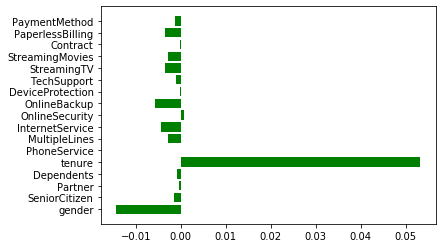

In [50]:
marks=[dfcs2[0],dfcs2[1],dfcs2[2],dfcs2[3],dfcs2[4],dfcs2[5],dfcs2[6],dfcs2[7],dfcs2[8],dfcs2[9],dfcs2[10],dfcs2[11],dfcs2[12],dfcs2[13],dfcs2[14],dfcs2[15],dfcs2[16]]
bars=('gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod')         
y=np.arange(len(bars))
plt.barh(y,marks,color='g')
plt.yticks(y,bars)
plt.show()

In [51]:
dfcs3 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(747):
    row = df_dfc.iloc[[i]]
    #747
    idx = 0
    dfcs = []
    for elem in encoded_elems:
        dfcs.append(sum(row.values[0][idx:idx+elem]))
        idx += elem
    dfcs3 = [(abs(dfcs[i]) + dfcs3[i]) for i in range(len(dfcs))] 

for i in range(17):
    dfcs3[i] = dfcs3[i] / 747
dfcs3         

[0.021232917240169978,
 0.04139348134497757,
 0.0029944935289121697,
 0.0027857634546217857,
 0.21282339143344003,
 0.0003462580897241577,
 0.004739914450468609,
 0.008954102151623131,
 0.0007255857896674043,
 0.006963238354054316,
 0.0014607094168625789,
 0.0026978405394391383,
 0.006957593557039936,
 0.0031832091611855204,
 0.0006230060538115421,
 0.003606522160155782,
 0.0020918963997746316]

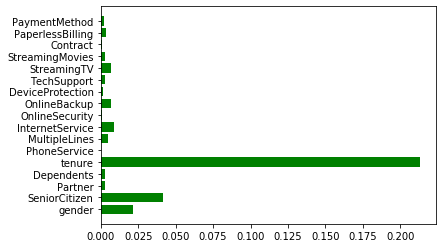

In [52]:
marks=[dfcs3[0],dfcs3[1],dfcs3[2],dfcs3[3],dfcs3[4],dfcs3[5],dfcs3[6],dfcs3[7],dfcs3[8],dfcs3[9],dfcs3[10],dfcs3[11],dfcs3[12],dfcs3[13],dfcs3[14],dfcs3[15],dfcs3[16]]
bars=('gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod')         
y=np.arange(len(bars))
plt.barh(y,marks,color='g')
plt.yticks(y,bars)
plt.show()